<a href="https://colab.research.google.com/github/mashruravi/eip-hvc/blob/master/colab/ResNet_50_age_LR_range_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
!cp /content/gdrive/My\ Drive/hvc_encoded_3.csv /content/
# `hvc_encoded.csv` and `resized` should be available
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  hvc_encoded_3.csv  resized/  sample_data/


In [0]:
import pandas as pd

In [3]:
df = pd.read_csv('hvc_encoded_3.csv')
df.head()

,image_path,gender_female,gender_male,qual_Average,qual_Bad,qual_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,bag_Daily/Office/Work Bag,bag_Grocery/Home/Plastic Bag,bag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.15)

In [5]:
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
# Columns for one-hot encoded labels
def get_columns_by_prefix(prefix):
  return [col for col in df if col.startswith(prefix)]

_gender_columns = get_columns_by_prefix('gender')
_qual_columns_ = get_columns_by_prefix('qual')
_age_columns_ = get_columns_by_prefix('age')
_weight_columns_ = get_columns_by_prefix('weight')
_bag_columns_ = get_columns_by_prefix('bag')
_footwear_columns_ = get_columns_by_prefix('footwear')
_emotion_columns_ = get_columns_by_prefix('emotion')
_bodypose_columns_ = get_columns_by_prefix('bodypose')

In [7]:
import tensorflow
print(tensorflow.__version__)

1.15.0


In [8]:
import keras
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
from __future__ import division

class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
    self.df = df
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.augmentation = augmentation

  def __len__(self):
    return int(np.ceil(self.df.shape[0] / self.batch_size))

  def __getitem__(self, index):
    """ return X=224,224,3,batch_size and y=num_classes,batch_size"""
    batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
    items = self.df.iloc[batch_slice]
    images = np.stack([cv2.imread(item['image_path']) for _, item in items.iterrows()])
    
    if self.augmentation is not None:
      images = self.augmentation.flow(images, shuffle=False, batch_size=self.batch_size).next()

    target = {
        'gender_output': items[_gender_columns].values,
        'imagequality_output': items[_qual_columns_].values,
        'age_output': items[_age_columns_].values,
        'weight_output': items[_weight_columns_].values,
        'bag_output': items[_bag_columns_].values,
        'footwear_output': items[_footwear_columns_].values,
        'emotion_output': items[_emotion_columns_].values,
        'bodypose_output': items[_bodypose_columns_].values
    }
    return images, target

  def on_epoch_end(self):
    """Shuffle data after each epoch"""
    if self.shuffle == True:
      self.df = self.df.sample(frac=1).reset_index(drop=True)

Using TensorFlow backend.


In [0]:
BATCH_SIZE=128
train_gen = DataGenerator(
    train_df,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augmentation=ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=False,
                                    rotation_range=10,
                                    width_shift_range=0.3,
                                    height_shift_range=0.1,
                                    zoom_range=0.2)
  )
valid_gen = DataGenerator(val_df, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
images, targets = next(iter(train_gen))

In [11]:
def get_unit_count(value_output):
  if (len(value_output.shape) > 1):
    return value_output.shape[1]
  else:
    return 1
num_units = { k.split("_output")[0]: get_unit_count(v) for k, v in targets.items() }
num_units

{'age': 5,
 'bag': 3,
 'bodypose': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'imagequality': 3,
 'weight': 4}

In [0]:
from keras import backend as K

class CyclicLR(keras.callbacks.Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
clr = CyclicLR(base_lr=0.00001, max_lr=0.01, step_size=910)

In [53]:
print(keras.__version__)

2.2.5


In [54]:
from keras.models import Model, Sequential
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from keras.layers import (
    Convolution2D,
    MaxPooling2D,
    AveragePooling2D,
    GlobalAveragePooling2D
)
from keras.layers import add
from keras.layers import BatchNormalization
from keras.regularizers import l2

from keras.applications.resnet_v2 import ResNet50V2

regularization_strength=0.0001

base_model = ResNet50V2(include_top=False)

neck = base_model.output
neck = GlobalAveragePooling2D()(neck)
neck = Dense(512, activation="relu")(neck)

def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(neck)
    neck = Dense(128, activation="relu")(neck)
    return neck

def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)
# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("imagequality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("bodypose", build_tower(neck))
model = Model(
    inputs=base_model.input,
    outputs=age
    # outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [56]:
history = model.fit_generator(
  generator=train_gen,
  validation_data=valid_gen,
  epochs=10,
  callbacks=[clr]
)

Epoch 1/10
 2/91 [..............................] - ETA: 7:01 - loss: 1.6734 - acc: 0.1875 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.637754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


91/91 [==============================] - 123s 1s/step - loss: 1.6140 - acc: 0.2335 - val_loss: 1.4752 - val_acc: 0.3581
Epoch 2/10
91/91 [==============================] - 116s 1s/step - loss: 1.5009 - acc: 0.3363 - val_loss: 1.4145 - val_acc: 0.4244
Epoch 3/10
91/91 [==============================] - 118s 1s/step - loss: 1.4698 - acc: 0.3709 - val_loss: 1.4010 - val_acc: 0.4249
Epoch 4/10
91/91 [==============================] - 118s 1s/step - loss: 1.4598 - acc: 0.3714 - val_loss: 1.4105 - val_acc: 0.4258
Epoch 5/10
91/91 [==============================] - 117s 1s/step - loss: 1.4446 - acc: 0.3808 - val_loss: 1.3873 - val_acc: 0.4194
Epoch 6/10
91/91 [==============================] - 118s 1s/step - loss: 1.4382 - acc: 0.3773 - val_loss: 1.3814 - val_acc: 0.4229
Epoch 7/10
91/91 [==============================] - 119s 1s/step - loss: 1.4283 - acc: 0.3860 - val_loss: 1.3802 - val_acc: 0.4273
Epoch 8/10
91/91 [==============================] - 118s 1s/step - loss: 1.4190 - acc: 0.3880 

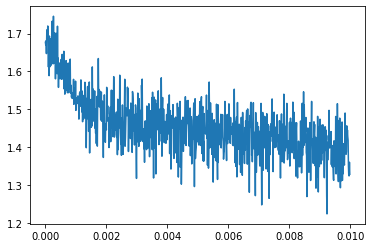

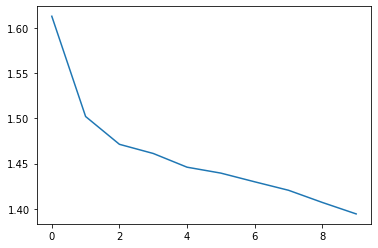

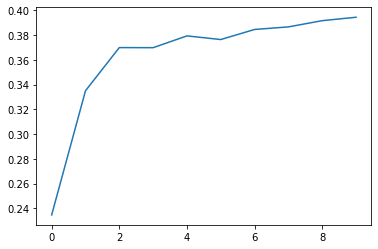

In [60]:
import matplotlib.pyplot as plt

plt.plot(clr.history['lr'], clr.history['loss'])
plt.show()

plt.plot(range(10), history.history['loss'])
plt.show()

plt.plot(range(10), history.history['acc'])
plt.show()

In [61]:
history2 = model.fit_generator(
  generator=train_gen,
  validation_data=valid_gen,
  epochs=20,
  callbacks=[clr]
)

Epoch 1/20
91/91 [==============================] - 121s 1s/step - loss: 1.3830 - acc: 0.3975 - val_loss: 1.3545 - val_acc: 0.4293
Epoch 2/20
91/91 [==============================] - 118s 1s/step - loss: 1.3729 - acc: 0.4006 - val_loss: 1.3379 - val_acc: 0.4317
Epoch 3/20
91/91 [==============================] - 118s 1s/step - loss: 1.3613 - acc: 0.4025 - val_loss: 1.3330 - val_acc: 0.4332
Epoch 4/20
91/91 [==============================] - 118s 1s/step - loss: 1.3506 - acc: 0.4086 - val_loss: 1.3374 - val_acc: 0.4165
Epoch 5/20
91/91 [==============================] - 118s 1s/step - loss: 1.3405 - acc: 0.4087 - val_loss: 1.3271 - val_acc: 0.4366
Epoch 6/20
91/91 [==============================] - 118s 1s/step - loss: 1.3335 - acc: 0.4186 - val_loss: 1.3264 - val_acc: 0.4253
Epoch 7/20
91/91 [==============================] - 118s 1s/step - loss: 1.3217 - acc: 0.4197 - val_loss: 1.3222 - val_acc: 0.4283
Epoch 8/20
91/91 [==============================] - 119s 1s/step - loss: 1.3186 - a

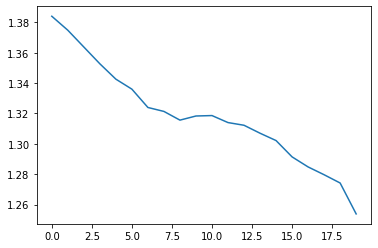

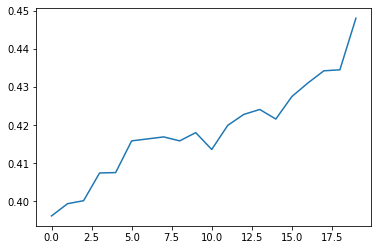

In [66]:
plt.plot(range(20), history2.history['loss'])
plt.show()

plt.plot(range(20), history2.history['acc'])
plt.show()

In [0]:
model.save_weights('model_weights.h5')